In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [32]:
#Potential Energy Gradient 

def potential_grad(x, lambd, h):
    d = len(x)
    x_ext = np.concatenate(([0.0], x, [0.0]))  #Boundry
    grad = np.zeros_like(x)

    for i in range(1, d+1):
        xi = x_ext[i]
        xim1 = x_ext[i-1]
        xip1 = x_ext[i+1]

        # Gradient of Term 1 
        grad_kin = lambd * (2 * xi - xim1 - xip1) / (h ** 2)

        # Gradient of Term 2
        grad_dw = - (2 / lambd) * (1 - xi ** 2) * xi

        # Total gradient
        grad[i - 1] = grad_kin + grad_dw

    return grad


In [33]:
#Euler Method for SDE simulation

def overdamped_langevin(x0, burn_in, samples, dt, T, lambd, h):
    d = len(x0)
    traj = np.zeros((burn_in+samples, d))
    x = x0.copy()

    for t in range(burn_in +samples):
        gradV = potential_grad(x, lambd=lambd, h=h)
        noise = np.sqrt(2.0 * dt *T) * np.random.randn(d)
        x -= dt * gradV + noise
        traj[t] = x

    return traj

In [34]:
#2D Marginal Visualization 

def visualize_2d_joint_pair(traj, i=0, j=1):

    plt.figure(figsize=(8, 6))
    plt.scatter(traj[:, i], traj[:, j], alpha=0.5, s=2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"2D Joint: x[{i+1}] vs x[{j+1}]", fontsize=14)
    plt.xlabel(f"x[{i+1}]")
    plt.ylabel(f"x[{j+1}]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [35]:
#All Marginal Visualization 

def visualize_all_1d_marginals(traj, bins=50):

    steps, d = traj.shape
    cols = min(d, 5)
    rows = math.ceil(d / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 2.5 * rows))
    axes = np.atleast_1d(np.array(axes)).flatten()

    for i in range(d):
        ax = axes[i]
        ax.hist(traj[:, i], bins=bins, density=True, alpha=0.7)
        ax.axvline(x=-1, color='red', linestyle='--', linewidth=1)
        ax.axvline(x=1, color='red', linestyle='--', linewidth=1)
        ax.set_title(f"x[{i+1}]")
        ax.grid(True)

    for j in range(d, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"1D Marginals for d = {d}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97]) 
    plt.show()

In [36]:
# Parameters
d = 20
x0 = np.random.randn(d)
burn_in = 10**6 
samples = 10**6
dt = .001
T = 8
lambd = 0.03
h = 1 / (1+d)

In [37]:
#Run Trajectory
traj = overdamped_langevin(x0, burn_in=burn_in, samples=samples, dt=dt, T=T, lambd=lambd, h=h)

#Remove the burn in period

traj = traj[burn_in:] 

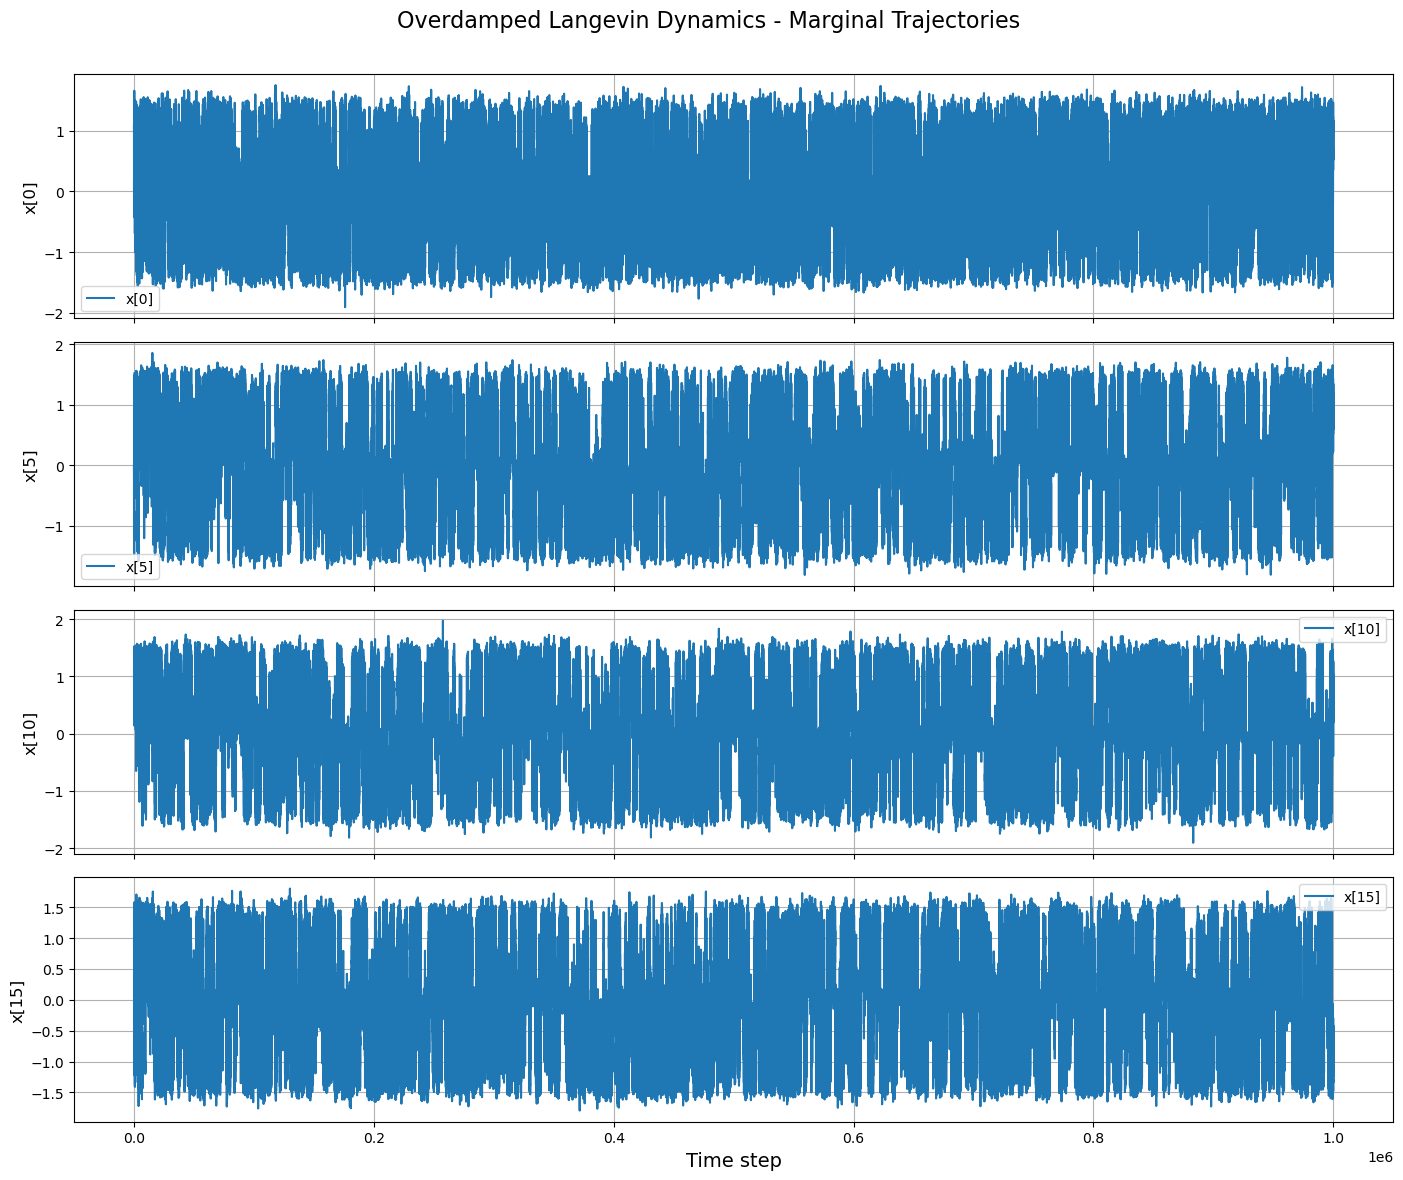

In [38]:
#Plot Marginal Trajectories

plot_nums = list(range(0, d, 5))
n_plots = len(plot_nums)

fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3 * n_plots), sharex=True)

for ax, i in zip(axes, plot_nums):
    ax.plot(traj[:, i], label=f'x[{i}]', color='tab:blue')
    ax.set_ylabel(f'x[{i}]', fontsize=12)
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Time step', fontsize=14)
fig.suptitle('Overdamped Langevin Dynamics - Marginal Trajectories', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  
plt.show()

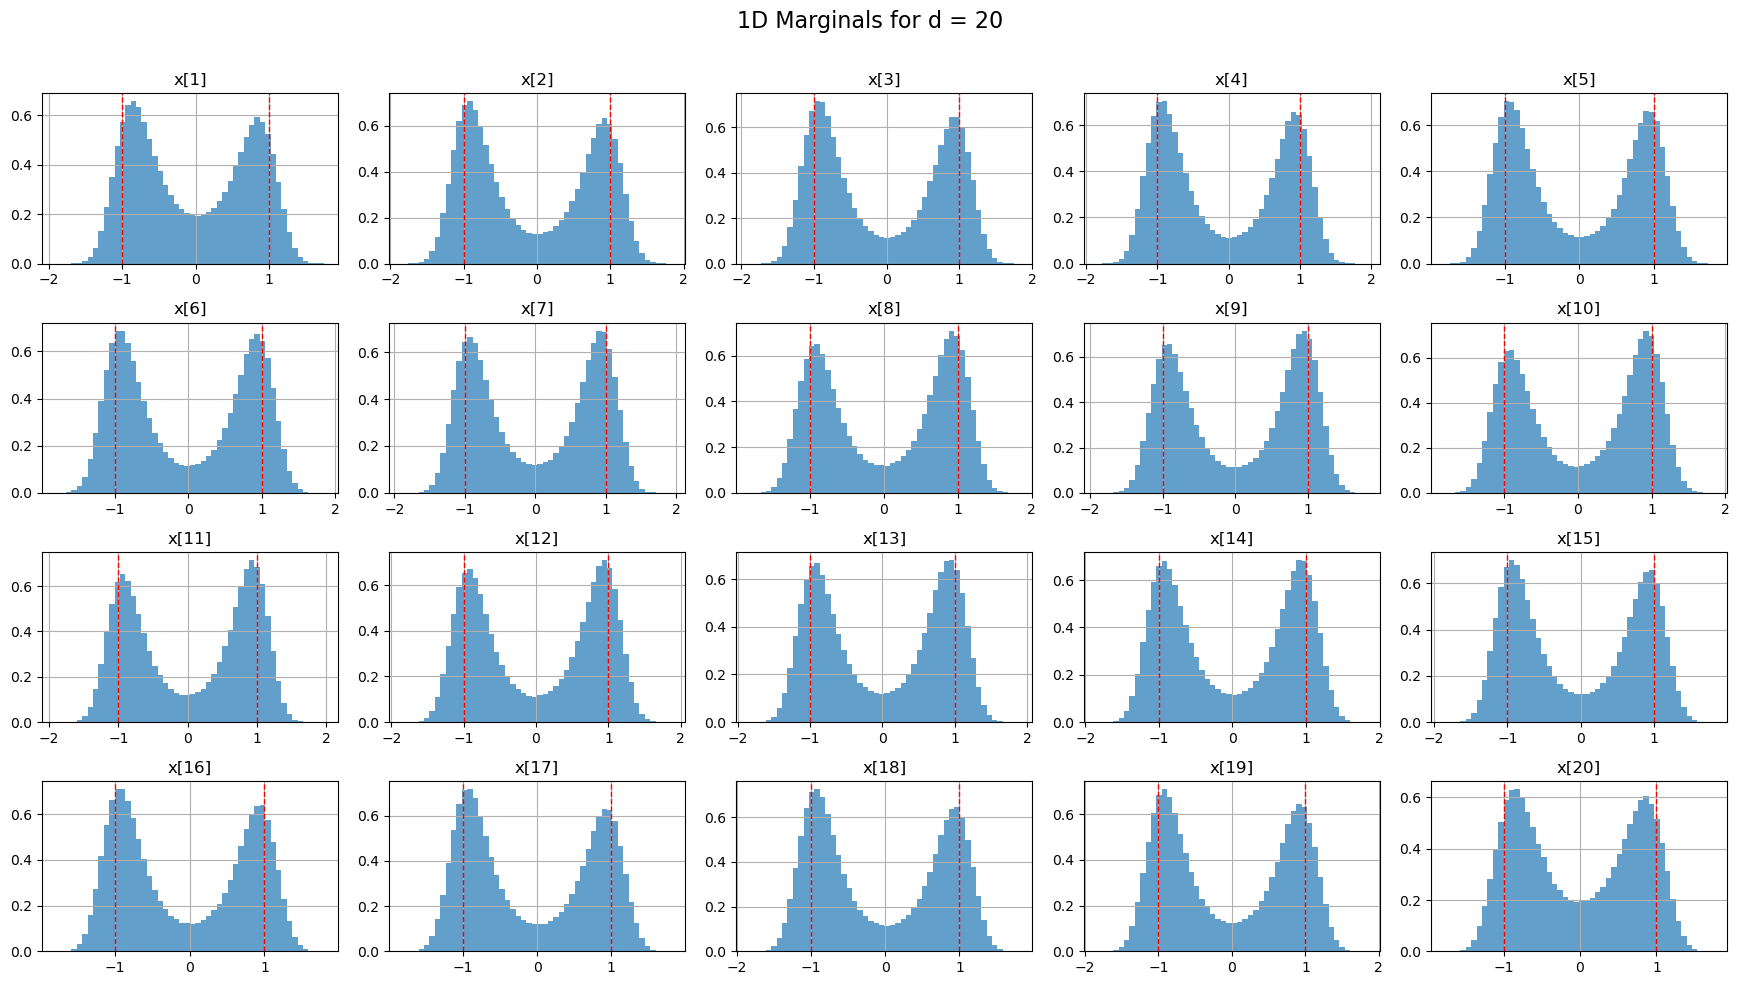

In [39]:
visualize_all_1d_marginals(traj, bins=50)

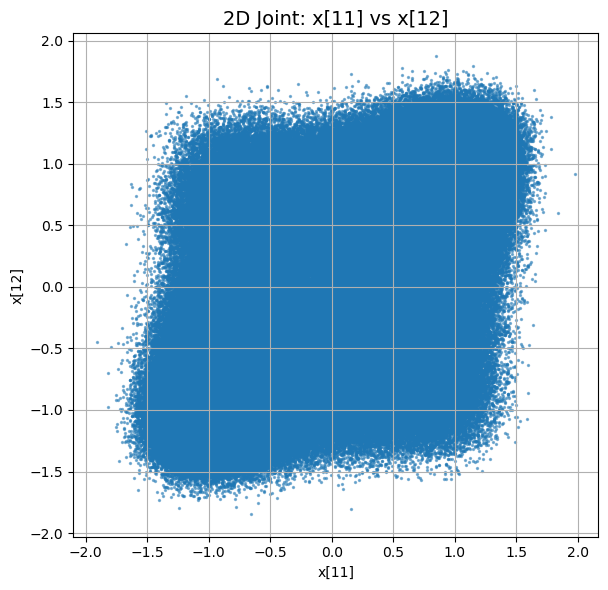

In [40]:
visualize_2d_joint_pair(traj=traj,i=10,j=11)

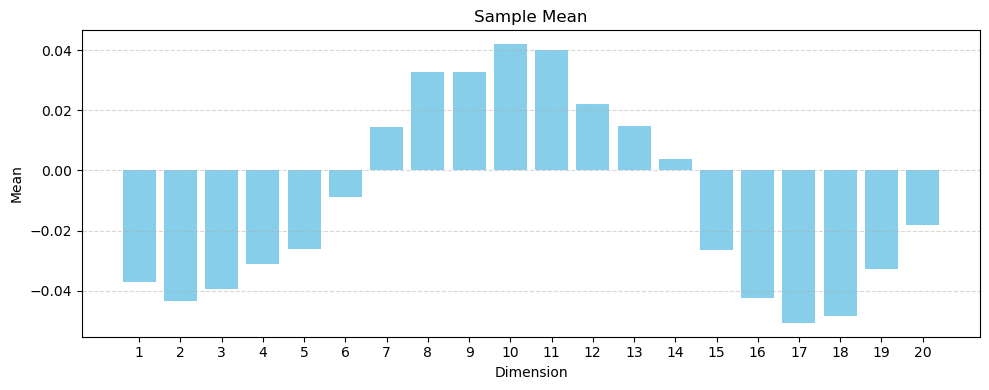

In [41]:
#Plot Sample Means

mean = np.mean(traj, axis=0)

plt.figure(figsize=(10, 4))
plt.bar(np.arange(1, d + 1), mean, color='skyblue')  
plt.title("Sample Mean")
plt.xlabel("Dimension")
plt.ylabel("Mean")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(np.arange(1, d + 1))  
plt.tight_layout()
plt.show()

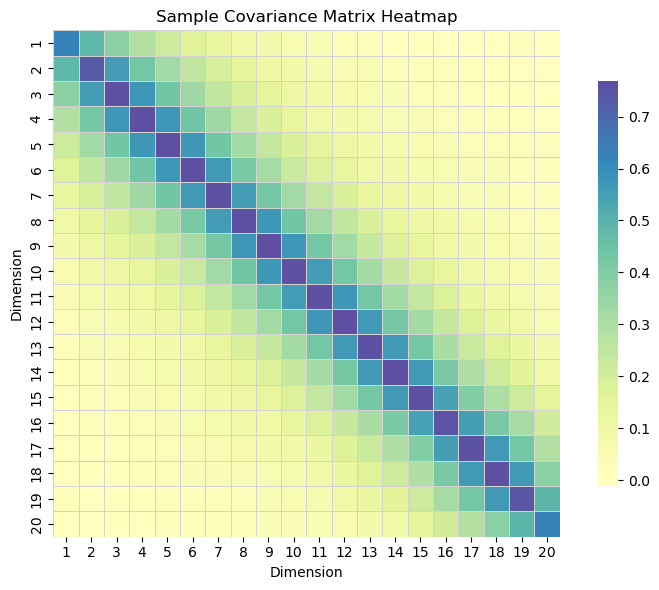

In [42]:
traj = traj - mean
sample_cov = traj.T @ traj / (traj.shape[0] - 1)

# Plot covariance heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sample_cov, cmap="Spectral", center=0, square=True, 
            cbar_kws={"shrink": 0.8},
            xticklabels=np.arange(1, d + 1),  # Start at 1
            yticklabels=np.arange(1, d + 1),
            linewidths=0.5, linecolor='lightgray')
plt.title("Sample Covariance Matrix Heatmap")
plt.xlabel("Dimension")
plt.ylabel("Dimension")
plt.tight_layout()
plt.show()